## ![CESI](./photo_livrable/Logo_cesi.png)

# Projet Leyenda
## Livrable 2 - Traitement d'images
|Auteurs|
|---|
|Karim Salhi
|Corentin Devrouete
|Hugo Larose
|Pierre-Alain Tietz

L'objectif de ce livrable est de débruiter un ensemble de photographies.
### Importation des librairies,
Dans un premier temps nous allons importer toutes les libraires nécessaire à notre débruitage :
- **Keras**, la bibliothèque Keras permet d'interagir avec les algorithmes de réseaux de neurones profonds et d'apprentissage automatique, notamment Tensorflow.
- **Tensorflow**, TensorFlow est un outil open source d'apprentissage automatique développé par Google.
- **Numpy**, NumPy est une bibliothèque pour langage de programmation Python, destinée à manipuler des matrices ou tableaux multidimensionnels ainsi que des fonctions mathématiques opérant sur ces tableaux.
- **Matplotlib**, est une bibliothèque utilisée pour tracer et visualiser des données à l'aide de graphiques.
- **Scikit-Learn**, est une bibliothèque utilisée pour l'apprentissage automatique et l'analyse de métriques
- **OpenCV** est une bibliothèque utilisée pour du traitement d'images.
- **Tqdm** est une bibliothèque utilisée pour visualiser des progress bar configurables"

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import pathlib
import os, cv2
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras import layers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Flatten, Reshape
from tensorflow.keras.models import Model
import keras.models as models
import keras.layers as layers
from keras.initializers import orthogonal

from skimage.util import random_noise
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

### Utilisation du GPU


Dans l'optique d’avoir de meilleures performances tout au long de ce projet notamment durant l’entraînement du modèle, nous avons décidé de faire passer le traitement des données par le GPU. Pour ce faire, la ligne ci-dessous nous indique si le système détecte un GPU qui peut être utilisé. (Seules les cartes Nvdia, avec Cuda installé, sont reconnues par Tensorflow).

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Initialisation des hyperparamètres

Ces paramètres nous servirons tout au long de notre programme d'intelligence artificielle :
>**BATCH_SIZE** : Cette variable est la taille du lot qui définit le nombre d'échantillons qui seront propagés à travers le réseau.
>
>**VALIDATION_SPLIT** : C'est un moyen de prédire l'ajustement d'un modèle à un ensemble de tests hypothétique lorsqu'un ensemble de tests explicite n'est pas disponible\n",
>
>**EPOCHS** : Une époque fait référence à un cycle à travers l'ensemble de données d'entraînement complet.
>
>**NOISE_FACTOR** : C'est le facteur de bruitage qui va définir si notre image va être fortement bruité ou non.

Ensuite nous definissons le chemin des répertoires vers le jeu de données et nos sauvegarde des modèles.

In [3]:
# Définitions des répertoire 
PATH_MODEL_SAVE = './PATH_MODEL_SAVE'
PATH_DATASET = pathlib.Path("/Volumes/G-DRIVE mobile USB-C/dataset/PASS_dataset")

NOISE_FACTOR = 0.2
IMAGE_HEIGHT, IMAGE_WIDTH = 256, 256
BATCH_SIZE = 9
VALIDATION_SPLIT = 0.2

### Création du jeu de données

Pour préparer le jeu de données, nous le séparons en deux sous-ensembles homogènes afin d'éviter la sous-représentation de classe. Le premier sous-ensemble permettra au modèle d'ajuster ses poids et par conséquent améliorer son débruitage. Le second nous permet d'évaluer la capacité du modèle à débruiter.
Nous créons au total 4 jeux de données : 
- Un dataset d'entraînement pour les images nettes
- Un dataset de validation pour les images nettes
- Un dataset d'entraînement pour les images bruitées
- Un dataset de validation pour les images bruitées

In [4]:
dataset_train = tf.keras.preprocessing.image_dataset_from_directory (
    PATH_DATASET,
    labels='inferred',
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    validation_split = VALIDATION_SPLIT,
    batch_size = BATCH_SIZE,
    seed = 42,
    subset = 'training',
    color_mode='rgb'
)

dataset_test = tf.keras.preprocessing.image_dataset_from_directory (
    PATH_DATASET,
    labels='inferred',
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    validation_split = VALIDATION_SPLIT,
    batch_size = BATCH_SIZE,
    seed = 42,
    subset = 'validation',
    color_mode='rgb'
)

x_train, _ = iter(dataset_train).next()
x_train = x_train.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), IMAGE_WIDTH, IMAGE_HEIGHT, 3))

x_test, _ = iter(dataset_test).next()
x_test = x_test.astype('float32') / 255.
x_test = np.reshape(x_test, (len(x_test), IMAGE_WIDTH, IMAGE_HEIGHT, 3))

print(x_train.shape)
print(x_test.shape)

Found 373230 files belonging to 20 classes.
Using 298584 files for training.
Metal device set to: Apple M1 Max


2022-01-16 18:46:31.712630: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-16 18:46:31.712784: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 373230 files belonging to 20 classes.
Using 74646 files for validation.


2022-01-16 18:50:27.409876: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(9, 256, 256, 3)
(9, 256, 256, 3)


### Bruitage des images

Etant donné que le dataset ne contient pas d'images bruitées, nous allons générer un bruit aléatoire gaussian sur les images. (On parle de bruit gaussien lorsque la densité de probabilité de cette variable est la loi gaussienne (ou loi normale)).Plus précisément, on va générer un bruit aléatoire x_train_noisy et x_test_noisy à partir de x_train et x_test.

Nous avons choisis un facteur de bruit de 0.2 pour bruité nos images.

In [5]:
# Définition des jeux de test et validation
x_train_noisy = x_train + np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) * NOISE_FACTOR
x_test_noisy = x_test + np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) * NOISE_FACTOR

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

### Affichage des images

Nous affichons ensuite les 5 premières images pour voir l'image de base ainsi que l'image bruitée. Nous avons bien nos 5 images de base puis nos 5 images issues du jeu de donnée bruitée.

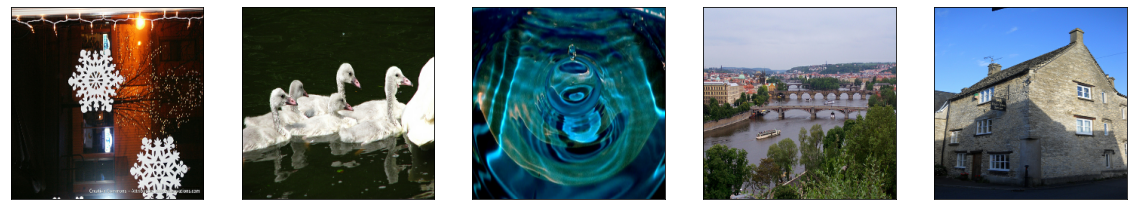

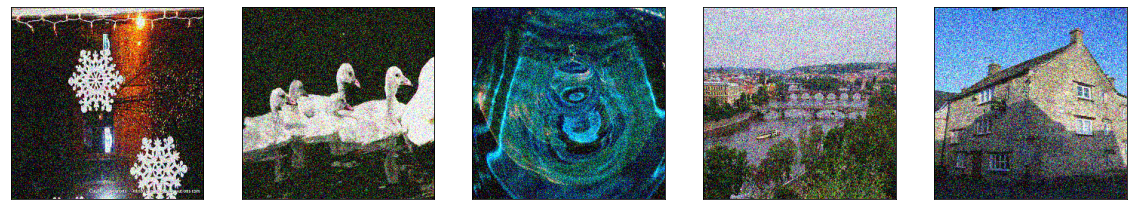

In [6]:
#Affichage d'image
def display_image(X, n, size = 20):
    plt.figure(figsize=(size, size))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(X[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

display_image(x_train,5)
display_image(x_train_noisy, 5)

### Principe de l'auto-encodeur

Les auto-encodeurs sont des algorithmes d’apprentissage non supervisé à base de réseaux de neurones artificiels, qui permettent de construire une nouvelle représentation d’un jeu de données. Généralement, celle-ci est plus compacte, et présente moins de descripteurs, ce qui permet de réduire la dimensionnalité du jeu de données. L’architecture d’un auto-encodeur est constitué de deux parties : l’encodeur et le décodeur.


L’encodeur est constitué par un ensemble de couches de neurones, qui traitent les données afin de construire de nouvelles représentations dites “encodées”. À leur tour, les couches de neurones du décodeur, reçoivent ces représentations et les traitent afin d’essayer de reconstruire les données de départ. Les différences entre les données reconstruites et les données initiales permettent de mesurer l’erreur commise par l’auto-encodeur. L’entraînement consiste à modifier les paramètres de l’auto-encodeur afin de réduire l’erreur de reconstruction mesurée sur les différents exemples du jeu de données.


La plupart du temps, on ne s’intéresse pas à la dernière couche du décodeur, qui contient uniquement la reconstruction des données initiales, mais plutôt à la nouvelle représentation créée par l’encodeur.

L’architecture la plus simple d’un auto-encodeur est semblable à un perceptron multicouches. Cependant, en fonction des données traitées, on peut utiliser différentes topologies de réseaux de neurones. Par exemple, des couches convolutives afin d’analyser des images ou des couches de neurones récurrentes pour traiter des séries temporelles ou des séquences.

À noter qu’à la différence d’un grand nombre de réseaux de neurones, les auto-encodeurs peuvent être entraînés de manière non-supervisée, ce qui permet d’appliquer ces méthodes à des jeux de données non annotés.

La figure suivante schématise un auto-encodeur simple, dont l’encodeur (encoder) traite des images (inputs), afin de les représenter comme des points dans un espace à deux dimensions (encoded representation), puis décode cette représentation (decoder), afin de retrouver les données de départ (output).

![Autoencoder](./photo_livrable/Autoencoder.png)

### Implémentation du modèle

Dans cette partie, nous allons implémenter le modèle d’auto-encodeur décrit précédemment. Nous définissons au préalable les variables utiles au modèle telles que le nombre d'épochs ou la taille du batch.

Nous utilisons un autoencoder convolutif, l’idée derrière les filtres a convolution est qu’ils permettent de trouver des patterns, des formes dans les images. Les CNN permettent en effet de déterminer de manière progressive les différentes formes puis de les assembler pour en trouver d’autres.

<blockquote> Un CNN applique généralement 3 types d’opérations différentes à une image afin d’en extraire les informations pertinentes.

Ces 3 types d’opérations sont les suivantes :
* La convolution
* Le pooling
* La fonction d’activation de type ReLU
</blockquote>

Nous utilisons donc les fonctions de tensorflow correspondantes pour créer notre modèle :

``Conv2D`` : Correspond à une couche de convolution.

``MaxPooling2D`` : Réalise une opération de Max Pooling.

``Conv2DTranspose`` : Correspond à une couche de déconvolution (inverse d'une opération de convolution).

``UpSampling2D`` : Double les dimensions d'une entrée.

Notre modèle d'auto-encodeur convolutif est composé de :
* un encodeur composé de trois couches convolutives
* un décodeur composé de l'inverse des couches de l'encodeur. 

Nous avons testés différents nombres de convolutions mais à partir de trois couches convolutives il n'y a plus d'améliorations lors du débruitage. D'ou notre choix de mettre trois couches convolutives dans notre modèle.

In [7]:
EPOCHS = 1000
BATCH_SIZE = 18

In [8]:
inputs = Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), name="input")
# ENCODING
# Convolution 1
conv1 = Conv2D(filters=8, kernel_size=(3, 3), padding='same', activation='relu', name="conv_1_encoder")(inputs)
pooling1 = MaxPooling2D((2, 2), padding="same", name="pooling_1")(conv1)

# Convolution 2
conv2 = Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu', name="conv_2_encoder")(pooling1)
pooling2 = MaxPooling2D((2, 2), padding="same", name="pooling_2")(conv2)

# Convolution 3
conv3 = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', name="conv_3_encoder")(pooling2)
encode = MaxPooling2D((2, 2), padding="same", name="pooling_3")(conv3)


In [9]:
# DECODING

# Déconvolution 1
conv4 = Conv2D(32, (3, 3),  activation="relu", padding="same")(encode)
upsamp1 = UpSampling2D((2, 2), name="sampling_1")(conv4)
#x = Conv2DTranspose(filters=256, kernel_size=(3, 3), strides=2, padding='same', activation='relu', name="conv_2_decoder")(encode)

# Déconvolution 2
conv5 = Conv2D(16, (3, 3),  activation="relu", padding="same")(upsamp1)
upsamp2 = UpSampling2D((2, 2), name="sampling_2")(conv5)
#x = Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, padding='same', activation='relu', name="conv_3_decoder")(x)

# Déconvolution 3
conv6 = Conv2D(8, (3, 3),  activation="relu", padding="same")(upsamp2)
upsamp3 = UpSampling2D((2, 2), name="sampling_3")(conv6)
#x = Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, padding='same', activation='relu', name="conv_4_decoder")(x)
 
# Output    
decode = Conv2D(3, (3, 3),  padding="same", activation="sigmoid", name="output")(upsamp3)

### Compliation du modèle
Nous donnons au modèle son entrée et sa sortie, ainsi que la configuration de sa fonction d'optimisation et sa fonction de perte.

La fonction d'optimisation a pour rôle d'optimiser la fonction de perte et de parvenir à des poids idéaux.

La fonction de perte calcule l'écart entre la sortie du modèle et le dataset de validation, produisant une valeur que l'entraînement du modèle cherche à réduire.

In [10]:
#Définition de l'autoencoder et compilation du modèle 
autoencoder = Model(inputs, decode, name="autoencoder")
autoencoder.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 conv_1_encoder (Conv2D)     (None, 256, 256, 8)       224       
                                                                 
 pooling_1 (MaxPooling2D)    (None, 128, 128, 8)       0         
                                                                 
 conv_2_encoder (Conv2D)     (None, 128, 128, 16)      1168      
                                                                 
 pooling_2 (MaxPooling2D)    (None, 64, 64, 16)        0         
                                                                 
 conv_3_encoder (Conv2D)     (None, 64, 64, 32)        4640      
                                                                 
 pooling_3 (MaxPooling2D)    (None, 32, 32, 32)        

In [11]:
callback_bestmodel = tf.keras.callbacks.ModelCheckpoint(filepath='./bestmodel.h5', verbose=0, save_best_only=True)
callbacks_list = [callback_bestmodel]

In [12]:
#On entraine l'autoencoder
history = autoencoder.fit(x_train_noisy, 
                          x_train, 
                          epochs= EPOCHS,
                          shuffle=True,
                          batch_size = BATCH_SIZE,  
                          validation_data=(x_test_noisy, x_test),
                          callbacks = callbacks_list
                         )

Epoch 1/1000


2022-01-16 18:50:33.076412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.6909 - accuracy: 0.3527 - val_loss: 0.6929 - val_accuracy: 0.5086


2022-01-16 18:50:34.795320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 2/1000
1/1 [==============================] - 0s 118ms/step - loss: 0.6870 - accuracy: 0.3515 - val_loss: 0.6919 - val_accuracy: 0.3962
Epoch 3/1000
1/1 [==============================] - 0s 146ms/step - loss: 0.6832 - accuracy: 0.3563 - val_loss: 0.6920 - val_accuracy: 0.3436
Epoch 4/1000
1/1 [==============================] - 0s 80ms/step - loss: 0.6790 - accuracy: 0.3617 - val_loss: 0.6932 - val_accuracy: 0.3569
Epoch 5/1000
1/1 [==============================] - 0s 83ms/step - loss: 0.6749 - accuracy: 0.3805 - val_loss: 0.6941 - val_accuracy: 0.3580
Epoch 6/1000
1/1 [==============================] - 0s 82ms/step - loss: 0.6708 - accuracy: 0.3827 - val_loss: 0.6926 - val_accuracy: 0.3612
Epoch 7/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.6660 - accuracy: 0.3827 - val_loss: 0.6872 - val_accuracy: 0.3760
Epoch 8/1000
1/1 [==============================] - 0s 116ms/step - loss: 0.6598 - accuracy: 0.3874 - val_loss: 0.6783 - val_accuracy: 0.4014
Epoch 9/1

1/1 [==============================] - 0s 106ms/step - loss: 0.5252 - accuracy: 0.6395 - val_loss: 0.5266 - val_accuracy: 0.6088
Epoch 60/1000
1/1 [==============================] - 0s 96ms/step - loss: 0.5244 - accuracy: 0.6546 - val_loss: 0.5269 - val_accuracy: 0.5855
Epoch 61/1000
1/1 [==============================] - 0s 117ms/step - loss: 0.5233 - accuracy: 0.6584 - val_loss: 0.5266 - val_accuracy: 0.5937
Epoch 62/1000
1/1 [==============================] - 0s 114ms/step - loss: 0.5226 - accuracy: 0.6658 - val_loss: 0.5267 - val_accuracy: 0.6023
Epoch 63/1000
1/1 [==============================] - 0s 80ms/step - loss: 0.5225 - accuracy: 0.6704 - val_loss: 0.5274 - val_accuracy: 0.5868
Epoch 64/1000
1/1 [==============================] - 0s 83ms/step - loss: 0.5228 - accuracy: 0.6687 - val_loss: 0.5269 - val_accuracy: 0.6120
Epoch 65/1000
1/1 [==============================] - 0s 81ms/step - loss: 0.5235 - accuracy: 0.6707 - val_loss: 0.5293 - val_accuracy: 0.5713
Epoch 66/1000
1/1

1/1 [==============================] - 0s 119ms/step - loss: 0.5141 - accuracy: 0.6812 - val_loss: 0.5128 - val_accuracy: 0.6310
Epoch 117/1000
1/1 [==============================] - 0s 88ms/step - loss: 0.5138 - accuracy: 0.6823 - val_loss: 0.5131 - val_accuracy: 0.6302
Epoch 118/1000
1/1 [==============================] - 0s 81ms/step - loss: 0.5133 - accuracy: 0.6817 - val_loss: 0.5130 - val_accuracy: 0.6300
Epoch 119/1000
1/1 [==============================] - 0s 108ms/step - loss: 0.5132 - accuracy: 0.6816 - val_loss: 0.5125 - val_accuracy: 0.6306
Epoch 120/1000
1/1 [==============================] - 0s 86ms/step - loss: 0.5134 - accuracy: 0.6822 - val_loss: 0.5135 - val_accuracy: 0.6309
Epoch 121/1000
1/1 [==============================] - 0s 114ms/step - loss: 0.5135 - accuracy: 0.6805 - val_loss: 0.5123 - val_accuracy: 0.6306
Epoch 122/1000
1/1 [==============================] - 0s 80ms/step - loss: 0.5134 - accuracy: 0.6823 - val_loss: 0.5127 - val_accuracy: 0.6302
Epoch 123/1

1/1 [==============================] - 0s 116ms/step - loss: 0.5111 - accuracy: 0.6870 - val_loss: 0.5088 - val_accuracy: 0.6270
Epoch 174/1000
1/1 [==============================] - 0s 118ms/step - loss: 0.5108 - accuracy: 0.6875 - val_loss: 0.5087 - val_accuracy: 0.6267
Epoch 175/1000
1/1 [==============================] - 0s 134ms/step - loss: 0.5108 - accuracy: 0.6873 - val_loss: 0.5095 - val_accuracy: 0.6258
Epoch 176/1000
1/1 [==============================] - 0s 121ms/step - loss: 0.5109 - accuracy: 0.6869 - val_loss: 0.5086 - val_accuracy: 0.6264
Epoch 177/1000
1/1 [==============================] - 0s 90ms/step - loss: 0.5108 - accuracy: 0.6876 - val_loss: 0.5087 - val_accuracy: 0.6259
Epoch 178/1000
1/1 [==============================] - 0s 91ms/step - loss: 0.5106 - accuracy: 0.6876 - val_loss: 0.5091 - val_accuracy: 0.6254
Epoch 179/1000
1/1 [==============================] - 0s 117ms/step - loss: 0.5107 - accuracy: 0.6874 - val_loss: 0.5084 - val_accuracy: 0.6262
Epoch 180

1/1 [==============================] - 0s 82ms/step - loss: 0.5096 - accuracy: 0.6899 - val_loss: 0.5061 - val_accuracy: 0.6194
Epoch 231/1000
1/1 [==============================] - 0s 84ms/step - loss: 0.5096 - accuracy: 0.6935 - val_loss: 0.5070 - val_accuracy: 0.6163
Epoch 232/1000
1/1 [==============================] - 0s 81ms/step - loss: 0.5092 - accuracy: 0.6929 - val_loss: 0.5061 - val_accuracy: 0.6185
Epoch 233/1000
1/1 [==============================] - 0s 107ms/step - loss: 0.5090 - accuracy: 0.6921 - val_loss: 0.5058 - val_accuracy: 0.6192
Epoch 234/1000
1/1 [==============================] - 0s 78ms/step - loss: 0.5091 - accuracy: 0.6921 - val_loss: 0.5069 - val_accuracy: 0.6165
Epoch 235/1000
1/1 [==============================] - 0s 148ms/step - loss: 0.5092 - accuracy: 0.6925 - val_loss: 0.5057 - val_accuracy: 0.6196
Epoch 236/1000
1/1 [==============================] - 0s 88ms/step - loss: 0.5093 - accuracy: 0.6937 - val_loss: 0.5070 - val_accuracy: 0.6167
Epoch 237/10

1/1 [==============================] - 0s 83ms/step - loss: 0.5080 - accuracy: 0.6954 - val_loss: 0.5044 - val_accuracy: 0.6143
Epoch 288/1000
1/1 [==============================] - 0s 120ms/step - loss: 0.5079 - accuracy: 0.6950 - val_loss: 0.5034 - val_accuracy: 0.6158
Epoch 289/1000
1/1 [==============================] - 0s 89ms/step - loss: 0.5077 - accuracy: 0.6952 - val_loss: 0.5037 - val_accuracy: 0.6147
Epoch 290/1000
1/1 [==============================] - 0s 78ms/step - loss: 0.5076 - accuracy: 0.6947 - val_loss: 0.5036 - val_accuracy: 0.6146
Epoch 291/1000
1/1 [==============================] - 0s 108ms/step - loss: 0.5076 - accuracy: 0.6947 - val_loss: 0.5034 - val_accuracy: 0.6150
Epoch 292/1000
1/1 [==============================] - 0s 82ms/step - loss: 0.5076 - accuracy: 0.6951 - val_loss: 0.5040 - val_accuracy: 0.6138
Epoch 293/1000
1/1 [==============================] - 0s 110ms/step - loss: 0.5077 - accuracy: 0.6948 - val_loss: 0.5033 - val_accuracy: 0.6160
Epoch 294/1

1/1 [==============================] - 0s 94ms/step - loss: 0.5067 - accuracy: 0.6960 - val_loss: 0.5026 - val_accuracy: 0.6142
Epoch 345/1000
1/1 [==============================] - 0s 110ms/step - loss: 0.5068 - accuracy: 0.6955 - val_loss: 0.5017 - val_accuracy: 0.6166
Epoch 346/1000
1/1 [==============================] - 0s 88ms/step - loss: 0.5069 - accuracy: 0.6956 - val_loss: 0.5032 - val_accuracy: 0.6142
Epoch 347/1000
1/1 [==============================] - 0s 82ms/step - loss: 0.5070 - accuracy: 0.6949 - val_loss: 0.5018 - val_accuracy: 0.6173
Epoch 348/1000
1/1 [==============================] - 0s 79ms/step - loss: 0.5072 - accuracy: 0.6960 - val_loss: 0.5039 - val_accuracy: 0.6135
Epoch 349/1000
1/1 [==============================] - 0s 77ms/step - loss: 0.5074 - accuracy: 0.6947 - val_loss: 0.5019 - val_accuracy: 0.6176
Epoch 350/1000
1/1 [==============================] - 0s 77ms/step - loss: 0.5075 - accuracy: 0.6965 - val_loss: 0.5043 - val_accuracy: 0.6130
Epoch 351/100

1/1 [==============================] - 0s 82ms/step - loss: 0.5058 - accuracy: 0.6861 - val_loss: 0.5006 - val_accuracy: 0.6179
Epoch 402/1000
1/1 [==============================] - 0s 79ms/step - loss: 0.5062 - accuracy: 0.6897 - val_loss: 0.5032 - val_accuracy: 0.6131
Epoch 403/1000
1/1 [==============================] - 0s 79ms/step - loss: 0.5065 - accuracy: 0.6802 - val_loss: 0.5010 - val_accuracy: 0.6165
Epoch 404/1000
1/1 [==============================] - 0s 83ms/step - loss: 0.5062 - accuracy: 0.6827 - val_loss: 0.5019 - val_accuracy: 0.6134
Epoch 405/1000
1/1 [==============================] - 0s 79ms/step - loss: 0.5057 - accuracy: 0.6871 - val_loss: 0.5005 - val_accuracy: 0.6168
Epoch 406/1000
1/1 [==============================] - 0s 115ms/step - loss: 0.5053 - accuracy: 0.6816 - val_loss: 0.5002 - val_accuracy: 0.6184
Epoch 407/1000
1/1 [==============================] - 0s 87ms/step - loss: 0.5055 - accuracy: 0.6830 - val_loss: 0.5017 - val_accuracy: 0.6170
Epoch 408/100

1/1 [==============================] - 0s 77ms/step - loss: 0.5046 - accuracy: 0.6865 - val_loss: 0.5001 - val_accuracy: 0.6153
Epoch 459/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.5046 - accuracy: 0.6866 - val_loss: 0.4997 - val_accuracy: 0.6154
Epoch 460/1000
1/1 [==============================] - 0s 88ms/step - loss: 0.5045 - accuracy: 0.6868 - val_loss: 0.4998 - val_accuracy: 0.6152
Epoch 461/1000
1/1 [==============================] - 0s 79ms/step - loss: 0.5045 - accuracy: 0.6873 - val_loss: 0.4998 - val_accuracy: 0.6151
Epoch 462/1000
1/1 [==============================] - 0s 76ms/step - loss: 0.5045 - accuracy: 0.6875 - val_loss: 0.4997 - val_accuracy: 0.6152
Epoch 463/1000
1/1 [==============================] - 0s 84ms/step - loss: 0.5045 - accuracy: 0.6871 - val_loss: 0.5000 - val_accuracy: 0.6152
Epoch 464/1000
1/1 [==============================] - 0s 114ms/step - loss: 0.5045 - accuracy: 0.6877 - val_loss: 0.4996 - val_accuracy: 0.6153
Epoch 465/10

1/1 [==============================] - 0s 112ms/step - loss: 0.5042 - accuracy: 0.6985 - val_loss: 0.4989 - val_accuracy: 0.6177
Epoch 516/1000
1/1 [==============================] - 0s 86ms/step - loss: 0.5043 - accuracy: 0.6939 - val_loss: 0.4998 - val_accuracy: 0.6185
Epoch 517/1000
1/1 [==============================] - 0s 77ms/step - loss: 0.5042 - accuracy: 0.6978 - val_loss: 0.4989 - val_accuracy: 0.6182
Epoch 518/1000
1/1 [==============================] - 0s 84ms/step - loss: 0.5040 - accuracy: 0.6992 - val_loss: 0.4991 - val_accuracy: 0.6182
Epoch 519/1000
1/1 [==============================] - 0s 78ms/step - loss: 0.5040 - accuracy: 0.6953 - val_loss: 0.4997 - val_accuracy: 0.6176
Epoch 520/1000
1/1 [==============================] - 0s 82ms/step - loss: 0.5040 - accuracy: 0.6978 - val_loss: 0.4989 - val_accuracy: 0.6172
Epoch 521/1000
1/1 [==============================] - 0s 88ms/step - loss: 0.5041 - accuracy: 0.6995 - val_loss: 0.4996 - val_accuracy: 0.6178
Epoch 522/100

1/1 [==============================] - 0s 82ms/step - loss: 0.5040 - accuracy: 0.7047 - val_loss: 0.5002 - val_accuracy: 0.6237
Epoch 573/1000
1/1 [==============================] - 0s 88ms/step - loss: 0.5042 - accuracy: 0.7060 - val_loss: 0.4984 - val_accuracy: 0.6272
Epoch 574/1000
1/1 [==============================] - 0s 82ms/step - loss: 0.5041 - accuracy: 0.7023 - val_loss: 0.4992 - val_accuracy: 0.6236
Epoch 575/1000
1/1 [==============================] - 0s 80ms/step - loss: 0.5037 - accuracy: 0.7046 - val_loss: 0.4983 - val_accuracy: 0.6246
Epoch 576/1000
1/1 [==============================] - 0s 108ms/step - loss: 0.5035 - accuracy: 0.7065 - val_loss: 0.4981 - val_accuracy: 0.6258
Epoch 577/1000
1/1 [==============================] - 0s 141ms/step - loss: 0.5036 - accuracy: 0.7041 - val_loss: 0.4992 - val_accuracy: 0.6234
Epoch 578/1000
1/1 [==============================] - 0s 81ms/step - loss: 0.5038 - accuracy: 0.7064 - val_loss: 0.4981 - val_accuracy: 0.6253
Epoch 579/10

1/1 [==============================] - 0s 77ms/step - loss: 0.5033 - accuracy: 0.7072 - val_loss: 0.4984 - val_accuracy: 0.6245
Epoch 630/1000
1/1 [==============================] - 0s 139ms/step - loss: 0.5033 - accuracy: 0.7079 - val_loss: 0.4974 - val_accuracy: 0.6261
Epoch 631/1000
1/1 [==============================] - 0s 82ms/step - loss: 0.5033 - accuracy: 0.7088 - val_loss: 0.4983 - val_accuracy: 0.6248
Epoch 632/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.5032 - accuracy: 0.7083 - val_loss: 0.4974 - val_accuracy: 0.6262
Epoch 633/1000
1/1 [==============================] - 0s 87ms/step - loss: 0.5032 - accuracy: 0.7081 - val_loss: 0.4982 - val_accuracy: 0.6242
Epoch 634/1000
1/1 [==============================] - 0s 114ms/step - loss: 0.5032 - accuracy: 0.7091 - val_loss: 0.4974 - val_accuracy: 0.6263
Epoch 635/1000
1/1 [==============================] - 0s 84ms/step - loss: 0.5032 - accuracy: 0.7073 - val_loss: 0.4982 - val_accuracy: 0.6246
Epoch 636/1

1/1 [==============================] - 0s 86ms/step - loss: 0.5028 - accuracy: 0.7105 - val_loss: 0.4976 - val_accuracy: 0.6249
Epoch 687/1000
1/1 [==============================] - 0s 116ms/step - loss: 0.5028 - accuracy: 0.7112 - val_loss: 0.4970 - val_accuracy: 0.6263
Epoch 688/1000
1/1 [==============================] - 0s 88ms/step - loss: 0.5029 - accuracy: 0.7106 - val_loss: 0.4979 - val_accuracy: 0.6248
Epoch 689/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.5030 - accuracy: 0.7103 - val_loss: 0.4970 - val_accuracy: 0.6268
Epoch 690/1000
1/1 [==============================] - 0s 87ms/step - loss: 0.5031 - accuracy: 0.7100 - val_loss: 0.4985 - val_accuracy: 0.6239
Epoch 691/1000
1/1 [==============================] - 0s 82ms/step - loss: 0.5033 - accuracy: 0.7103 - val_loss: 0.4972 - val_accuracy: 0.6272
Epoch 692/1000
1/1 [==============================] - 0s 103ms/step - loss: 0.5035 - accuracy: 0.7097 - val_loss: 0.4997 - val_accuracy: 0.6230
Epoch 693/1

1/1 [==============================] - 0s 89ms/step - loss: 0.5026 - accuracy: 0.7129 - val_loss: 0.4972 - val_accuracy: 0.6252
Epoch 744/1000
1/1 [==============================] - 0s 75ms/step - loss: 0.5025 - accuracy: 0.7128 - val_loss: 0.4967 - val_accuracy: 0.6264
Epoch 745/1000
1/1 [==============================] - 0s 75ms/step - loss: 0.5025 - accuracy: 0.7134 - val_loss: 0.4971 - val_accuracy: 0.6252
Epoch 746/1000
1/1 [==============================] - 0s 78ms/step - loss: 0.5025 - accuracy: 0.7133 - val_loss: 0.4967 - val_accuracy: 0.6264
Epoch 747/1000
1/1 [==============================] - 0s 76ms/step - loss: 0.5025 - accuracy: 0.7125 - val_loss: 0.4968 - val_accuracy: 0.6257
Epoch 748/1000
1/1 [==============================] - 0s 80ms/step - loss: 0.5024 - accuracy: 0.7127 - val_loss: 0.4967 - val_accuracy: 0.6261
Epoch 749/1000
1/1 [==============================] - 0s 78ms/step - loss: 0.5024 - accuracy: 0.7125 - val_loss: 0.4968 - val_accuracy: 0.6264
Epoch 750/1000

1/1 [==============================] - 0s 83ms/step - loss: 0.5023 - accuracy: 0.7162 - val_loss: 0.4969 - val_accuracy: 0.6268
Epoch 801/1000
1/1 [==============================] - 0s 114ms/step - loss: 0.5023 - accuracy: 0.7156 - val_loss: 0.4963 - val_accuracy: 0.6282
Epoch 802/1000
1/1 [==============================] - 0s 90ms/step - loss: 0.5023 - accuracy: 0.7165 - val_loss: 0.4969 - val_accuracy: 0.6269
Epoch 803/1000
1/1 [==============================] - 0s 118ms/step - loss: 0.5023 - accuracy: 0.7162 - val_loss: 0.4963 - val_accuracy: 0.6285
Epoch 804/1000
1/1 [==============================] - 0s 92ms/step - loss: 0.5023 - accuracy: 0.7156 - val_loss: 0.4969 - val_accuracy: 0.6269
Epoch 805/1000
1/1 [==============================] - 0s 119ms/step - loss: 0.5023 - accuracy: 0.7164 - val_loss: 0.4962 - val_accuracy: 0.6288
Epoch 806/1000
1/1 [==============================] - 0s 91ms/step - loss: 0.5023 - accuracy: 0.7154 - val_loss: 0.4969 - val_accuracy: 0.6273
Epoch 807/1

1/1 [==============================] - 0s 82ms/step - loss: 0.5019 - accuracy: 0.7186 - val_loss: 0.4962 - val_accuracy: 0.6305
Epoch 858/1000
1/1 [==============================] - 0s 83ms/step - loss: 0.5019 - accuracy: 0.7191 - val_loss: 0.4961 - val_accuracy: 0.6307
Epoch 859/1000
1/1 [==============================] - 0s 82ms/step - loss: 0.5019 - accuracy: 0.7184 - val_loss: 0.4962 - val_accuracy: 0.6308
Epoch 860/1000
1/1 [==============================] - 0s 89ms/step - loss: 0.5019 - accuracy: 0.7184 - val_loss: 0.4961 - val_accuracy: 0.6311
Epoch 861/1000
1/1 [==============================] - 0s 80ms/step - loss: 0.5019 - accuracy: 0.7185 - val_loss: 0.4962 - val_accuracy: 0.6311
Epoch 862/1000
1/1 [==============================] - 0s 120ms/step - loss: 0.5019 - accuracy: 0.7182 - val_loss: 0.4960 - val_accuracy: 0.6316
Epoch 863/1000
1/1 [==============================] - 0s 86ms/step - loss: 0.5019 - accuracy: 0.7186 - val_loss: 0.4962 - val_accuracy: 0.6311
Epoch 864/100

1/1 [==============================] - 0s 106ms/step - loss: 0.5020 - accuracy: 0.7145 - val_loss: 0.4959 - val_accuracy: 0.6308
Epoch 915/1000
1/1 [==============================] - 0s 83ms/step - loss: 0.5020 - accuracy: 0.7201 - val_loss: 0.4959 - val_accuracy: 0.6308
Epoch 916/1000
1/1 [==============================] - 0s 79ms/step - loss: 0.5018 - accuracy: 0.7170 - val_loss: 0.4964 - val_accuracy: 0.6318
Epoch 917/1000
1/1 [==============================] - 0s 112ms/step - loss: 0.5019 - accuracy: 0.7180 - val_loss: 0.4958 - val_accuracy: 0.6321
Epoch 918/1000
1/1 [==============================] - 0s 86ms/step - loss: 0.5019 - accuracy: 0.7277 - val_loss: 0.4961 - val_accuracy: 0.6320
Epoch 919/1000
1/1 [==============================] - 0s 77ms/step - loss: 0.5018 - accuracy: 0.7276 - val_loss: 0.4963 - val_accuracy: 0.6333
Epoch 920/1000
1/1 [==============================] - 0s 107ms/step - loss: 0.5018 - accuracy: 0.7191 - val_loss: 0.4958 - val_accuracy: 0.6329
Epoch 921/1

1/1 [==============================] - 0s 83ms/step - loss: 0.5015 - accuracy: 0.7264 - val_loss: 0.4956 - val_accuracy: 0.6409
Epoch 972/1000
1/1 [==============================] - 0s 125ms/step - loss: 0.5015 - accuracy: 0.7257 - val_loss: 0.4955 - val_accuracy: 0.6411
Epoch 973/1000
1/1 [==============================] - 0s 91ms/step - loss: 0.5015 - accuracy: 0.7259 - val_loss: 0.4956 - val_accuracy: 0.6412
Epoch 974/1000
1/1 [==============================] - 0s 80ms/step - loss: 0.5015 - accuracy: 0.7265 - val_loss: 0.4955 - val_accuracy: 0.6413
Epoch 975/1000
1/1 [==============================] - 0s 120ms/step - loss: 0.5015 - accuracy: 0.7261 - val_loss: 0.4955 - val_accuracy: 0.6414
Epoch 976/1000
1/1 [==============================] - 0s 89ms/step - loss: 0.5015 - accuracy: 0.7264 - val_loss: 0.4956 - val_accuracy: 0.6415
Epoch 977/1000
1/1 [==============================] - 0s 113ms/step - loss: 0.5015 - accuracy: 0.7267 - val_loss: 0.4955 - val_accuracy: 0.6417
Epoch 978/1

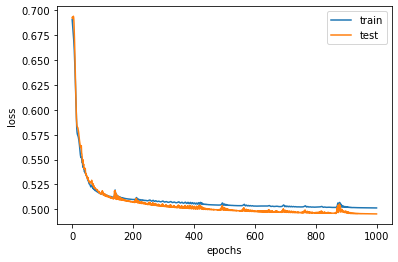

In [13]:
# On affiche les courbes loss du train et test 
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.xlabel("epochs")
plt.ylabel(list(history.history.keys())[0])
plt.show()

## Interpretation des courbes 

Nous voyons sur ce graphique l'évolution de la fonction perte au cours de l'entraînement, démontrant ainsi l'amélioration de notre modèle.

Nous remarquons que sur le jeu de donnée d'entraînement ou de valdiation nos résultats sont semblable. Notre modèle n'est donc pas sur entraîné ou sous entraîné.



## Comparaison des images

Avec le modèle entraîné, nous pouvons maintenant réaliser des prédictions, c'est-à-dire exécuter le processus de denoising par l'auto-encodeur. Nous affichons ainsi des images nettes et les images traitées pour les comparer.

2022-01-16 18:52:11.735801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


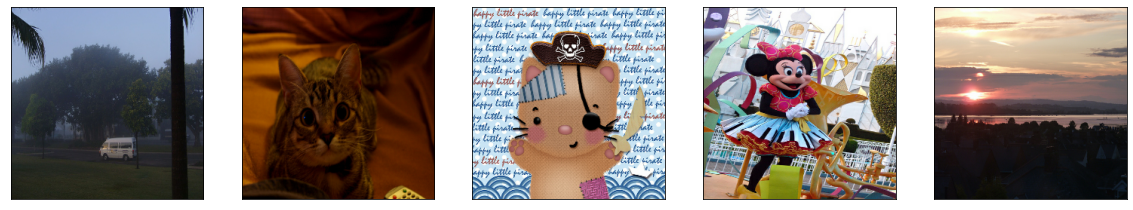

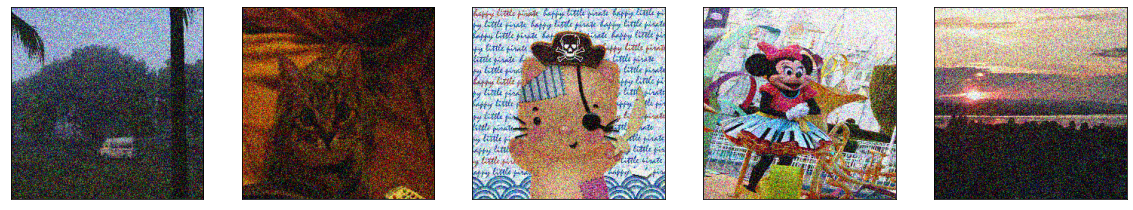

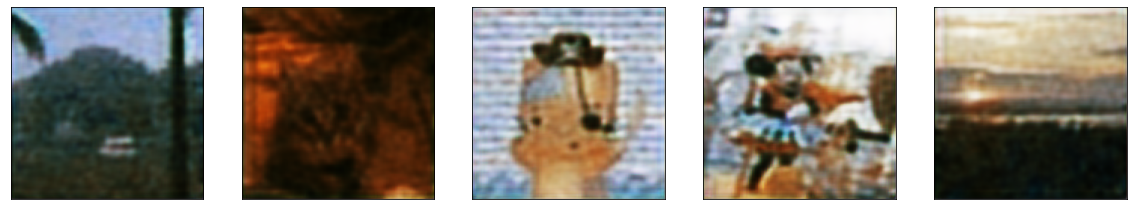

In [14]:
predictions = autoencoder.predict(x_test_noisy)
display_image(x_test, 5)
display_image(x_test_noisy, 5)
display_image(predictions, 5)

In [15]:
# On sauvegarde le modèle pour le réutiliser
autoencoder.save('PATH_MODEL_SAVE')
model = tf.keras.models.load_model(PATH_MODEL_SAVE)

2022-01-16 18:52:12.581970: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: PATH_MODEL_SAVE/assets


## Utilisation sur un autre jeu de donnée
Nous utilisons une image bruitée issue d'un autre jeu de donnée que le notre, afin d'appliquer le traitement de notre modèle.

Le modèle est chargé à partir d'une précédente version sauvegardée afin de ne pas avoir à réaliser l'étape d'entraînement de nouveau.

In [17]:
# On met l'image de test dans le bon format
input_img = PIL.Image.open('./noisy_001.jpg').convert('RGB')
input_img = input_img.resize((256, 256), PIL.Image.ANTIALIAS)
input_img = np.array(input_img, dtype=np.float32)
input_img = input_img.astype('float32')/255
input_img = tf.expand_dims(input_img, axis=0)

# Comparaison des images

Avec le modèle entraîné, nous pouvons maintenant réaliser des prédictions, c'est-à-dire exécuter le processus de denoising par l'auto-encodeur. Nous affichons ainsi des images nettes et les images traitées pour les comparer.

2022-01-16 18:54:30.852850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


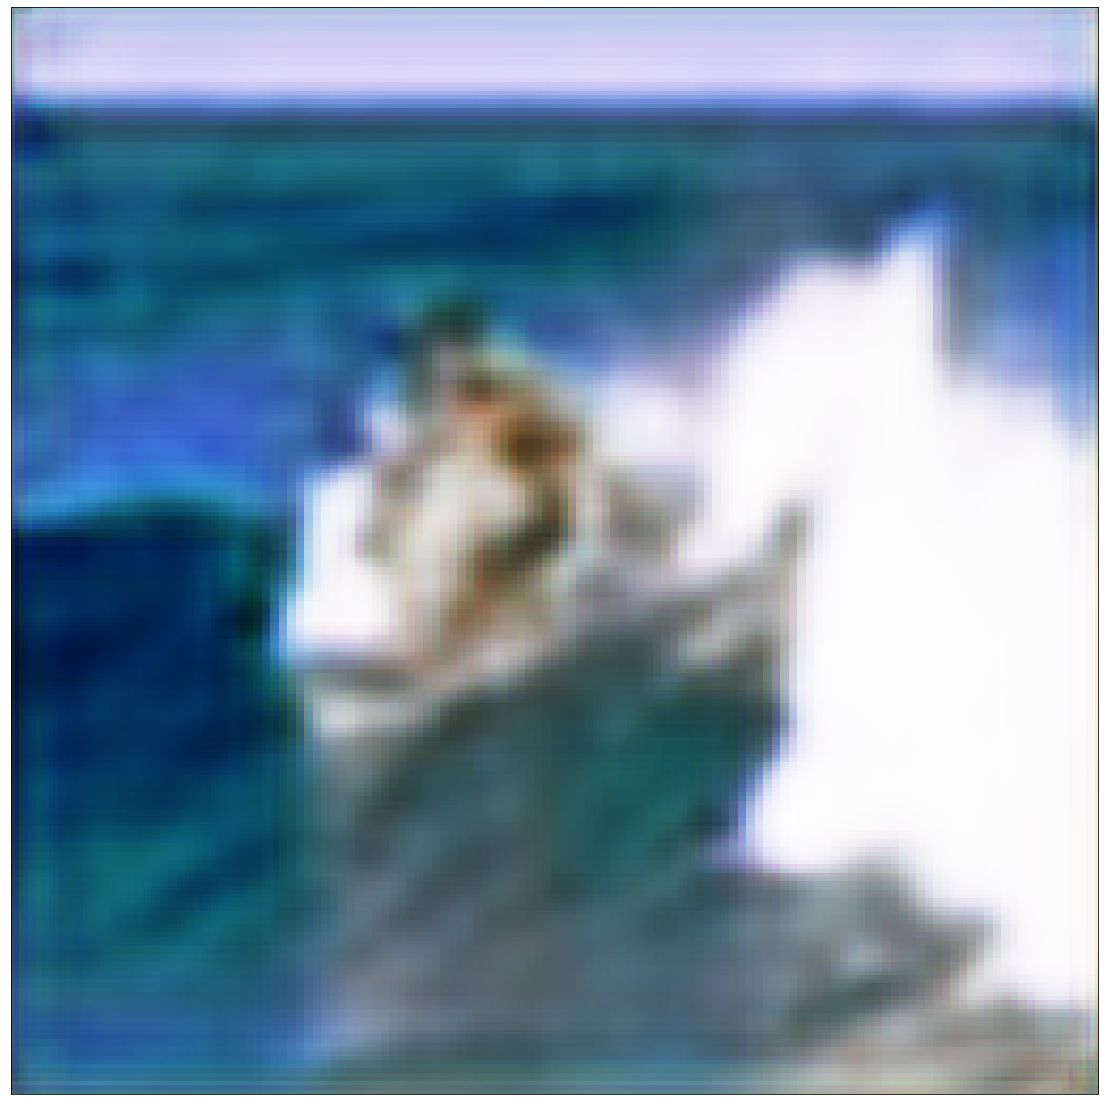

In [18]:
# Prédire une version débruité
denoised = model.predict(input_img)
display_image(denoised, n=1)

Les images qui sont affichées sont le résultat de notre opération de débruitage et ne nous donne pas un résultat très convainquant. <br/>
Le résultat visuel de notre modèle pouvant être amélioré, nous avons cherché un moyen de le rendre plus performant.

## Amélioration du modèle 

Cette partie a pour but d'augmenter la qualité de nos résultats. Pour cela, nous avons choisi d'implémenter une architecture de DAE (Denoising AutoEncoder)

Dans cette architecture, nous utilisons une fonction d'activation leaky Relu ainsi que la méthode de batch normalization.<br/>

> **Leaky Relu:** Il s'agit d'une fonction d'activation qui se base sur RELU, mais elle a une petite pente pour les valeurs négatives au lieu d'une pente plate. Le coefficient de pente est déterminé avant l'entraînement et ajuster au cours des époques. Comme le montre la représentation ci-dessous.

![Leaky_Relu.PNG](./photo_livrable/leakyrelu.png)

> **Batch Normalization:** Il s'agit d'une méthode utilisée pour rendre le réseau de neurones artificiels plus rapide et plus stable en normalisant les données à l'entrée des couches.

In [19]:
#Encodeur
def Conv2DLayer(x, filters, kernel, strides, padding, block_id, kernel_init=orthogonal()):
    prefix = f'block_{block_id}_'
    x = Conv2D(filters, kernel_size=kernel, strides=strides, padding=padding,
                      kernel_initializer=kernel_init, name=prefix+'conv')(x)
    x = layers.LeakyReLU(name=prefix+'lrelu')(x)
    x = layers.Dropout(0.2, name=prefix+'drop')((x))
    x = layers.BatchNormalization(name=prefix+'conv_bn')(x)
    return x

**Conv2DTranspose()** est une opération de convolution dont le noyau est appris lors de l'entraînement de notre modèle. L'utilisation de Conv2DTranspose suréchantillonnera également son entrée, mais la principale différence est que le modèle doit apprendre quel est le meilleur suréchantillonnage pour sa tâche.

In [20]:
#Décodeur
def Transpose_Conv2D(x, filters, kernel, strides, padding, block_id, kernel_init=orthogonal()):
    prefix = f'block_{block_id}_'
    x = Conv2DTranspose(filters, kernel_size=kernel, strides=strides, padding=padding,
                               kernel_initializer=kernel_init, name=prefix+'de-conv')(x)
    x = layers.LeakyReLU(name=prefix+'lrelu')(x)
    x = layers.Dropout(0.2, name=prefix+'drop')((x))
    x = layers.BatchNormalization(name=prefix+'conv_bn')(x)
    return x

### Implémentation du modèle

Nous définissons et entraînons notre modèle de la même manière que le précedent. 

In [21]:
def AutoEncoder(input_shape):
    inputs = Input(shape=input_shape)
    
    conv1 = Conv2DLayer(inputs, 64, 3, strides=1, padding='same', block_id=1)
    conv2 = Conv2DLayer(conv1, 64, 3, strides=2, padding='same', block_id=2)
    
    conv3 = Conv2DLayer(conv2, 128, 5, strides=2, padding='same', block_id=3)
    
    conv4 = Conv2DLayer(conv3, 128, 3, strides=1, padding='same', block_id=4)
    conv5 = Conv2DLayer(conv4, 256, 5, strides=2, padding='same', block_id=5)

    conv6 = Conv2DLayer(conv5, 512, 3, strides=2, padding='same', block_id=6)
    
    deconv1 = Transpose_Conv2D(conv6, 512, 3, strides=2, padding='same', block_id=7)

    skip1 = layers.concatenate([deconv1, conv5], name='skip1')
    conv7 = Conv2DLayer(skip1, 256, 3, strides=1, padding='same', block_id=8)
    deconv2 = Transpose_Conv2D(conv7, 128, 3, strides=2, padding='same', block_id=9)
    
    skip2 = layers.concatenate([deconv2, conv3], name='skip2')
    conv8 = Conv2DLayer(skip2, 128, 5, strides=1, padding='same', block_id=10)
    deconv3 = Transpose_Conv2D(conv8, 64, 3, strides=2, padding='same', block_id=11)
    
    skip3 = layers.concatenate([deconv3, conv2], name='skip3')
    conv9 = Conv2DLayer(skip3, 64, 5, strides=1, padding='same', block_id=12)
    deconv4 = Transpose_Conv2D(conv9, 64, 3, strides=2, padding='same', block_id=13)
    
    skip3 = layers.concatenate([deconv4, conv1])
    conv10 = layers.Conv2D(3, 3, strides=1, padding='same', activation='sigmoid', kernel_initializer=orthogonal(), name='final_conv')(skip3)

    
    return models.Model(inputs=inputs, outputs=conv10)

model = AutoEncoder((IMAGE_HEIGHT, IMAGE_WIDTH, 3))
model_opt = tf.keras.optimizers.Adam(learning_rate=0.002)
model.compile(optimizer=model_opt, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block_1_conv (Conv2D)          (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block_1_lrelu (LeakyReLU)      (None, 256, 256, 64  0           ['block_1_conv[0][0]']           
                                )                                                             

In [22]:
callback_bestmodel_improved = tf.keras.callbacks.ModelCheckpoint(filepath=pathlib.Path(r"./new.h5"), verbose=0, save_best_only=True)
callbacks_list_improved = [callback_bestmodel_improved]

In [23]:
history = model.fit(x_train_noisy, x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    callbacks = callbacks_list_improved
)

Epoch 1/1000


2022-01-16 18:54:43.529902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 0.8567 - accuracy: 0.2934

2022-01-16 18:54:47.912885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 5s 5s/step - loss: 0.8567 - accuracy: 0.2934 - val_loss: 0.6799 - val_accuracy: 0.2377
Epoch 2/1000
1/1 [==============================] - 1s 552ms/step - loss: 0.6303 - accuracy: 0.3097 - val_loss: 1.0175 - val_accuracy: 0.2549
Epoch 3/1000
1/1 [==============================] - 0s 434ms/step - loss: 0.5968 - accuracy: 0.4165 - val_loss: 4.3378 - val_accuracy: 0.2862
Epoch 4/1000
1/1 [==============================] - 0s 439ms/step - loss: 0.5889 - accuracy: 0.4768 - val_loss: 20.1401 - val_accuracy: 0.3133
Epoch 5/1000
1/1 [==============================] - 0s 435ms/step - loss: 0.5802 - accuracy: 0.5307 - val_loss: 0.8014 - val_accuracy: 0.2715
Epoch 6/1000
1/1 [==============================] - 0s 440ms/step - loss: 0.5806 - accuracy: 0.5372 - val_loss: 2.2902 - val_accuracy: 0.3514
Epoch 7/1000
1/1 [==============================] - 1s 579ms/step - loss: 0.5658 - accuracy: 0.5393 - val_loss: 4.3385 - val_accuracy: 0.3336
Epoch 8/1000
1/1 [===

1/1 [==============================] - 0s 438ms/step - loss: 0.5051 - accuracy: 0.5953 - val_loss: 0.7428 - val_accuracy: 0.2941
Epoch 59/1000
1/1 [==============================] - 0s 434ms/step - loss: 0.5048 - accuracy: 0.5971 - val_loss: 0.7445 - val_accuracy: 0.2923
Epoch 60/1000
1/1 [==============================] - 0s 437ms/step - loss: 0.5046 - accuracy: 0.5977 - val_loss: 0.7431 - val_accuracy: 0.2883
Epoch 61/1000
1/1 [==============================] - 1s 507ms/step - loss: 0.5044 - accuracy: 0.5977 - val_loss: 0.7408 - val_accuracy: 0.2851
Epoch 62/1000
1/1 [==============================] - 0s 434ms/step - loss: 0.5042 - accuracy: 0.5979 - val_loss: 0.7394 - val_accuracy: 0.2838
Epoch 63/1000
1/1 [==============================] - 0s 434ms/step - loss: 0.5040 - accuracy: 0.5983 - val_loss: 0.7404 - val_accuracy: 0.2830
Epoch 64/1000
1/1 [==============================] - 0s 447ms/step - loss: 0.5038 - accuracy: 0.5988 - val_loss: 0.7424 - val_accuracy: 0.2815
Epoch 65/1000

1/1 [==============================] - 0s 434ms/step - loss: 0.4978 - accuracy: 0.6567 - val_loss: 0.6365 - val_accuracy: 0.2411
Epoch 116/1000
1/1 [==============================] - 0s 431ms/step - loss: 0.4977 - accuracy: 0.6583 - val_loss: 0.6363 - val_accuracy: 0.2421
Epoch 117/1000
1/1 [==============================] - 0s 431ms/step - loss: 0.4976 - accuracy: 0.6589 - val_loss: 0.6362 - val_accuracy: 0.2418
Epoch 118/1000
1/1 [==============================] - 0s 432ms/step - loss: 0.4976 - accuracy: 0.6576 - val_loss: 0.6340 - val_accuracy: 0.2476
Epoch 119/1000
1/1 [==============================] - 0s 433ms/step - loss: 0.4975 - accuracy: 0.6605 - val_loss: 0.6334 - val_accuracy: 0.2489
Epoch 120/1000
1/1 [==============================] - 0s 429ms/step - loss: 0.4974 - accuracy: 0.6606 - val_loss: 0.6341 - val_accuracy: 0.2466
Epoch 121/1000
1/1 [==============================] - 0s 435ms/step - loss: 0.4974 - accuracy: 0.6619 - val_loss: 0.6339 - val_accuracy: 0.2505
Epoch 1

Epoch 172/1000
1/1 [==============================] - 0s 441ms/step - loss: 0.4950 - accuracy: 0.7155 - val_loss: 0.6186 - val_accuracy: 0.4748
Epoch 173/1000
1/1 [==============================] - 1s 589ms/step - loss: 0.4950 - accuracy: 0.7130 - val_loss: 0.6184 - val_accuracy: 0.4627
Epoch 174/1000
1/1 [==============================] - 1s 605ms/step - loss: 0.4949 - accuracy: 0.7138 - val_loss: 0.6175 - val_accuracy: 0.4509
Epoch 175/1000
1/1 [==============================] - 1s 607ms/step - loss: 0.4949 - accuracy: 0.7127 - val_loss: 0.6171 - val_accuracy: 0.4499
Epoch 176/1000
1/1 [==============================] - 0s 442ms/step - loss: 0.4949 - accuracy: 0.7120 - val_loss: 0.6172 - val_accuracy: 0.4557
Epoch 177/1000
1/1 [==============================] - 0s 432ms/step - loss: 0.4949 - accuracy: 0.7134 - val_loss: 0.6172 - val_accuracy: 0.4678
Epoch 178/1000
1/1 [==============================] - 0s 486ms/step - loss: 0.4948 - accuracy: 0.7183 - val_loss: 0.6173 - val_accuracy:

Epoch 229/1000
1/1 [==============================] - 0s 449ms/step - loss: 0.4937 - accuracy: 0.7435 - val_loss: 0.6013 - val_accuracy: 0.5875
Epoch 230/1000
1/1 [==============================] - 1s 589ms/step - loss: 0.4938 - accuracy: 0.7479 - val_loss: 0.6002 - val_accuracy: 0.5763
Epoch 231/1000
1/1 [==============================] - 1s 609ms/step - loss: 0.4936 - accuracy: 0.7453 - val_loss: 0.5999 - val_accuracy: 0.5561
Epoch 232/1000
1/1 [==============================] - 0s 464ms/step - loss: 0.4937 - accuracy: 0.7416 - val_loss: 0.6005 - val_accuracy: 0.5597
Epoch 233/1000
1/1 [==============================] - 0s 430ms/step - loss: 0.4936 - accuracy: 0.7471 - val_loss: 0.6004 - val_accuracy: 0.5733
Epoch 234/1000
1/1 [==============================] - 0s 429ms/step - loss: 0.4936 - accuracy: 0.7505 - val_loss: 0.6004 - val_accuracy: 0.5809
Epoch 235/1000
1/1 [==============================] - 1s 677ms/step - loss: 0.4936 - accuracy: 0.7462 - val_loss: 0.5994 - val_accuracy:

Epoch 286/1000
1/1 [==============================] - 1s 622ms/step - loss: 0.4928 - accuracy: 0.7691 - val_loss: 0.5795 - val_accuracy: 0.6178
Epoch 287/1000
1/1 [==============================] - 0s 468ms/step - loss: 0.4928 - accuracy: 0.7650 - val_loss: 0.5801 - val_accuracy: 0.6061
Epoch 288/1000
1/1 [==============================] - 0s 432ms/step - loss: 0.4927 - accuracy: 0.7612 - val_loss: 0.5804 - val_accuracy: 0.5954
Epoch 289/1000
1/1 [==============================] - 1s 603ms/step - loss: 0.4927 - accuracy: 0.7625 - val_loss: 0.5792 - val_accuracy: 0.6072
Epoch 290/1000
1/1 [==============================] - 1s 627ms/step - loss: 0.4927 - accuracy: 0.7695 - val_loss: 0.5781 - val_accuracy: 0.6219
Epoch 291/1000
1/1 [==============================] - 1s 762ms/step - loss: 0.4927 - accuracy: 0.7699 - val_loss: 0.5777 - val_accuracy: 0.6265
Epoch 292/1000
1/1 [==============================] - 1s 607ms/step - loss: 0.4927 - accuracy: 0.7683 - val_loss: 0.5777 - val_accuracy:

Epoch 343/1000
1/1 [==============================] - 1s 622ms/step - loss: 0.4922 - accuracy: 0.7788 - val_loss: 0.5560 - val_accuracy: 0.6229
Epoch 344/1000
1/1 [==============================] - 0s 468ms/step - loss: 0.4922 - accuracy: 0.7794 - val_loss: 0.5571 - val_accuracy: 0.6228
Epoch 345/1000
1/1 [==============================] - 0s 434ms/step - loss: 0.4922 - accuracy: 0.7819 - val_loss: 0.5562 - val_accuracy: 0.6174
Epoch 346/1000
1/1 [==============================] - 1s 591ms/step - loss: 0.4921 - accuracy: 0.7814 - val_loss: 0.5548 - val_accuracy: 0.6133
Epoch 347/1000
1/1 [==============================] - 0s 448ms/step - loss: 0.4921 - accuracy: 0.7793 - val_loss: 0.5562 - val_accuracy: 0.6232
Epoch 348/1000
1/1 [==============================] - 0s 468ms/step - loss: 0.4921 - accuracy: 0.7786 - val_loss: 0.5549 - val_accuracy: 0.6182
Epoch 349/1000
1/1 [==============================] - 1s 601ms/step - loss: 0.4921 - accuracy: 0.7729 - val_loss: 0.5542 - val_accuracy:

Epoch 400/1000
1/1 [==============================] - 0s 462ms/step - loss: 0.4916 - accuracy: 0.7914 - val_loss: 0.5330 - val_accuracy: 0.6543
Epoch 401/1000
1/1 [==============================] - 1s 587ms/step - loss: 0.4916 - accuracy: 0.7899 - val_loss: 0.5307 - val_accuracy: 0.6548
Epoch 402/1000
1/1 [==============================] - 0s 444ms/step - loss: 0.4916 - accuracy: 0.7874 - val_loss: 0.5326 - val_accuracy: 0.6542
Epoch 403/1000
1/1 [==============================] - 0s 437ms/step - loss: 0.4916 - accuracy: 0.7917 - val_loss: 0.5310 - val_accuracy: 0.6561
Epoch 404/1000
1/1 [==============================] - 1s 622ms/step - loss: 0.4916 - accuracy: 0.7886 - val_loss: 0.5299 - val_accuracy: 0.6596
Epoch 405/1000
1/1 [==============================] - 0s 443ms/step - loss: 0.4916 - accuracy: 0.7900 - val_loss: 0.5307 - val_accuracy: 0.6548
Epoch 406/1000
1/1 [==============================] - 0s 427ms/step - loss: 0.4916 - accuracy: 0.7906 - val_loss: 0.5317 - val_accuracy:

Epoch 457/1000
1/1 [==============================] - 0s 439ms/step - loss: 0.4912 - accuracy: 0.7986 - val_loss: 0.5123 - val_accuracy: 0.6863
Epoch 458/1000
1/1 [==============================] - 1s 589ms/step - loss: 0.4912 - accuracy: 0.7970 - val_loss: 0.5107 - val_accuracy: 0.6968
Epoch 459/1000
1/1 [==============================] - 1s 606ms/step - loss: 0.4912 - accuracy: 0.7993 - val_loss: 0.5106 - val_accuracy: 0.6985
Epoch 460/1000
1/1 [==============================] - 0s 445ms/step - loss: 0.4912 - accuracy: 0.7941 - val_loss: 0.5119 - val_accuracy: 0.6878
Epoch 461/1000
1/1 [==============================] - 1s 595ms/step - loss: 0.4911 - accuracy: 0.7950 - val_loss: 0.5090 - val_accuracy: 0.6944
Epoch 462/1000
1/1 [==============================] - 0s 445ms/step - loss: 0.4912 - accuracy: 0.7984 - val_loss: 0.5108 - val_accuracy: 0.6992
Epoch 463/1000
1/1 [==============================] - 0s 428ms/step - loss: 0.4911 - accuracy: 0.7977 - val_loss: 0.5101 - val_accuracy:

Epoch 514/1000
1/1 [==============================] - 0s 492ms/step - loss: 0.4908 - accuracy: 0.8041 - val_loss: 0.4984 - val_accuracy: 0.7307
Epoch 515/1000
1/1 [==============================] - 0s 436ms/step - loss: 0.4908 - accuracy: 0.8045 - val_loss: 0.4990 - val_accuracy: 0.7203
Epoch 516/1000
1/1 [==============================] - 1s 596ms/step - loss: 0.4908 - accuracy: 0.8041 - val_loss: 0.4965 - val_accuracy: 0.7185
Epoch 517/1000
1/1 [==============================] - 0s 464ms/step - loss: 0.4909 - accuracy: 0.7976 - val_loss: 0.4979 - val_accuracy: 0.7207
Epoch 518/1000
1/1 [==============================] - 1s 648ms/step - loss: 0.4908 - accuracy: 0.8033 - val_loss: 0.4960 - val_accuracy: 0.7327
Epoch 519/1000
1/1 [==============================] - 0s 440ms/step - loss: 0.4909 - accuracy: 0.8054 - val_loss: 0.4965 - val_accuracy: 0.7290
Epoch 520/1000
1/1 [==============================] - 1s 611ms/step - loss: 0.4907 - accuracy: 0.8060 - val_loss: 0.4960 - val_accuracy:

Epoch 571/1000
1/1 [==============================] - 0s 442ms/step - loss: 0.4905 - accuracy: 0.8093 - val_loss: 0.4896 - val_accuracy: 0.7443
Epoch 572/1000
1/1 [==============================] - 0s 431ms/step - loss: 0.4904 - accuracy: 0.8074 - val_loss: 0.4892 - val_accuracy: 0.7359
Epoch 573/1000
1/1 [==============================] - 0s 441ms/step - loss: 0.4903 - accuracy: 0.8087 - val_loss: 0.4886 - val_accuracy: 0.7335
Epoch 574/1000
1/1 [==============================] - 0s 433ms/step - loss: 0.4904 - accuracy: 0.8123 - val_loss: 0.4884 - val_accuracy: 0.7396
Epoch 575/1000
1/1 [==============================] - 0s 432ms/step - loss: 0.4903 - accuracy: 0.8093 - val_loss: 0.4895 - val_accuracy: 0.7426
Epoch 576/1000
1/1 [==============================] - 0s 433ms/step - loss: 0.4903 - accuracy: 0.8080 - val_loss: 0.4902 - val_accuracy: 0.7395
Epoch 577/1000
1/1 [==============================] - 1s 594ms/step - loss: 0.4903 - accuracy: 0.8093 - val_loss: 0.4876 - val_accuracy:

Epoch 628/1000
1/1 [==============================] - 0s 430ms/step - loss: 0.4899 - accuracy: 0.8169 - val_loss: 0.4854 - val_accuracy: 0.7493
Epoch 629/1000
1/1 [==============================] - 0s 436ms/step - loss: 0.4899 - accuracy: 0.8158 - val_loss: 0.4846 - val_accuracy: 0.7397
Epoch 630/1000
1/1 [==============================] - 0s 439ms/step - loss: 0.4899 - accuracy: 0.8165 - val_loss: 0.4857 - val_accuracy: 0.7486
Epoch 631/1000
1/1 [==============================] - 0s 434ms/step - loss: 0.4900 - accuracy: 0.8173 - val_loss: 0.4853 - val_accuracy: 0.7419
Epoch 632/1000
1/1 [==============================] - 0s 435ms/step - loss: 0.4899 - accuracy: 0.8205 - val_loss: 0.4857 - val_accuracy: 0.7449
Epoch 633/1000
1/1 [==============================] - 0s 435ms/step - loss: 0.4900 - accuracy: 0.8164 - val_loss: 0.4849 - val_accuracy: 0.7375
Epoch 634/1000
1/1 [==============================] - 0s 430ms/step - loss: 0.4900 - accuracy: 0.8144 - val_loss: 0.4869 - val_accuracy:

Epoch 685/1000
1/1 [==============================] - 0s 429ms/step - loss: 0.4896 - accuracy: 0.8186 - val_loss: 0.4829 - val_accuracy: 0.7477
Epoch 686/1000
1/1 [==============================] - 0s 432ms/step - loss: 0.4896 - accuracy: 0.8201 - val_loss: 0.4838 - val_accuracy: 0.7511
Epoch 687/1000
1/1 [==============================] - 0s 430ms/step - loss: 0.4897 - accuracy: 0.8244 - val_loss: 0.4827 - val_accuracy: 0.7422
Epoch 688/1000
1/1 [==============================] - 0s 438ms/step - loss: 0.4896 - accuracy: 0.8222 - val_loss: 0.4818 - val_accuracy: 0.7350
Epoch 689/1000
1/1 [==============================] - 0s 431ms/step - loss: 0.4896 - accuracy: 0.8182 - val_loss: 0.4834 - val_accuracy: 0.7577
Epoch 690/1000
1/1 [==============================] - 0s 430ms/step - loss: 0.4895 - accuracy: 0.8231 - val_loss: 0.4822 - val_accuracy: 0.7417
Epoch 691/1000
1/1 [==============================] - 0s 429ms/step - loss: 0.4896 - accuracy: 0.8215 - val_loss: 0.4824 - val_accuracy:

Epoch 742/1000
1/1 [==============================] - 0s 442ms/step - loss: 0.4892 - accuracy: 0.8245 - val_loss: 0.4809 - val_accuracy: 0.7413
Epoch 743/1000
1/1 [==============================] - 0s 450ms/step - loss: 0.4893 - accuracy: 0.8218 - val_loss: 0.4805 - val_accuracy: 0.7481
Epoch 744/1000
1/1 [==============================] - 0s 434ms/step - loss: 0.4893 - accuracy: 0.8223 - val_loss: 0.4838 - val_accuracy: 0.7556
Epoch 745/1000
1/1 [==============================] - 0s 430ms/step - loss: 0.4893 - accuracy: 0.8232 - val_loss: 0.4826 - val_accuracy: 0.7521
Epoch 746/1000
1/1 [==============================] - 0s 427ms/step - loss: 0.4893 - accuracy: 0.8261 - val_loss: 0.4804 - val_accuracy: 0.7530
Epoch 747/1000
1/1 [==============================] - 0s 431ms/step - loss: 0.4892 - accuracy: 0.8246 - val_loss: 0.4818 - val_accuracy: 0.7437
Epoch 748/1000
1/1 [==============================] - 0s 431ms/step - loss: 0.4892 - accuracy: 0.8219 - val_loss: 0.4832 - val_accuracy:

Epoch 799/1000
1/1 [==============================] - 0s 443ms/step - loss: 0.4889 - accuracy: 0.8243 - val_loss: 0.4818 - val_accuracy: 0.7436
Epoch 800/1000
1/1 [==============================] - 0s 432ms/step - loss: 0.4889 - accuracy: 0.8273 - val_loss: 0.4829 - val_accuracy: 0.7556
Epoch 801/1000
1/1 [==============================] - 0s 434ms/step - loss: 0.4888 - accuracy: 0.8330 - val_loss: 0.4817 - val_accuracy: 0.7484
Epoch 802/1000
1/1 [==============================] - 0s 428ms/step - loss: 0.4888 - accuracy: 0.8278 - val_loss: 0.4805 - val_accuracy: 0.7418
Epoch 803/1000
1/1 [==============================] - 0s 434ms/step - loss: 0.4889 - accuracy: 0.8313 - val_loss: 0.4846 - val_accuracy: 0.7610
Epoch 804/1000
1/1 [==============================] - 0s 431ms/step - loss: 0.4890 - accuracy: 0.8278 - val_loss: 0.4805 - val_accuracy: 0.7482
Epoch 805/1000
1/1 [==============================] - 0s 429ms/step - loss: 0.4890 - accuracy: 0.8290 - val_loss: 0.4803 - val_accuracy:

Epoch 856/1000
1/1 [==============================] - 0s 430ms/step - loss: 0.4884 - accuracy: 0.8316 - val_loss: 0.4815 - val_accuracy: 0.7517
Epoch 857/1000
1/1 [==============================] - 0s 431ms/step - loss: 0.4885 - accuracy: 0.8298 - val_loss: 0.4827 - val_accuracy: 0.7602
Epoch 858/1000
1/1 [==============================] - 0s 431ms/step - loss: 0.4884 - accuracy: 0.8328 - val_loss: 0.4801 - val_accuracy: 0.7470
Epoch 859/1000
1/1 [==============================] - 0s 433ms/step - loss: 0.4884 - accuracy: 0.8328 - val_loss: 0.4805 - val_accuracy: 0.7552
Epoch 860/1000
1/1 [==============================] - 0s 433ms/step - loss: 0.4883 - accuracy: 0.8308 - val_loss: 0.4815 - val_accuracy: 0.7649
Epoch 861/1000
1/1 [==============================] - 0s 431ms/step - loss: 0.4884 - accuracy: 0.8265 - val_loss: 0.4814 - val_accuracy: 0.7577
Epoch 862/1000
1/1 [==============================] - 0s 434ms/step - loss: 0.4884 - accuracy: 0.8334 - val_loss: 0.4806 - val_accuracy:

Epoch 913/1000
1/1 [==============================] - 0s 440ms/step - loss: 0.4880 - accuracy: 0.8355 - val_loss: 0.4816 - val_accuracy: 0.7673
Epoch 914/1000
1/1 [==============================] - 0s 440ms/step - loss: 0.4880 - accuracy: 0.8362 - val_loss: 0.4809 - val_accuracy: 0.7622
Epoch 915/1000
1/1 [==============================] - 0s 446ms/step - loss: 0.4881 - accuracy: 0.8365 - val_loss: 0.4808 - val_accuracy: 0.7625
Epoch 916/1000
1/1 [==============================] - 0s 436ms/step - loss: 0.4880 - accuracy: 0.8338 - val_loss: 0.4815 - val_accuracy: 0.7524
Epoch 917/1000
1/1 [==============================] - 0s 435ms/step - loss: 0.4881 - accuracy: 0.8265 - val_loss: 0.4810 - val_accuracy: 0.7647
Epoch 918/1000
1/1 [==============================] - 0s 429ms/step - loss: 0.4879 - accuracy: 0.8384 - val_loss: 0.4802 - val_accuracy: 0.7596
Epoch 919/1000
1/1 [==============================] - 0s 436ms/step - loss: 0.4881 - accuracy: 0.8377 - val_loss: 0.4828 - val_accuracy:

Epoch 970/1000
1/1 [==============================] - 0s 432ms/step - loss: 0.4877 - accuracy: 0.8412 - val_loss: 0.4812 - val_accuracy: 0.7647
Epoch 971/1000
1/1 [==============================] - 0s 482ms/step - loss: 0.4877 - accuracy: 0.8413 - val_loss: 0.4815 - val_accuracy: 0.7634
Epoch 972/1000
1/1 [==============================] - 0s 431ms/step - loss: 0.4877 - accuracy: 0.8382 - val_loss: 0.4806 - val_accuracy: 0.7544
Epoch 973/1000
1/1 [==============================] - 0s 428ms/step - loss: 0.4877 - accuracy: 0.8382 - val_loss: 0.4818 - val_accuracy: 0.7671
Epoch 974/1000
1/1 [==============================] - 0s 430ms/step - loss: 0.4877 - accuracy: 0.8413 - val_loss: 0.4805 - val_accuracy: 0.7675
Epoch 975/1000
1/1 [==============================] - 0s 430ms/step - loss: 0.4876 - accuracy: 0.8412 - val_loss: 0.4801 - val_accuracy: 0.7528
Epoch 976/1000
1/1 [==============================] - 0s 430ms/step - loss: 0.4877 - accuracy: 0.8391 - val_loss: 0.4815 - val_accuracy:

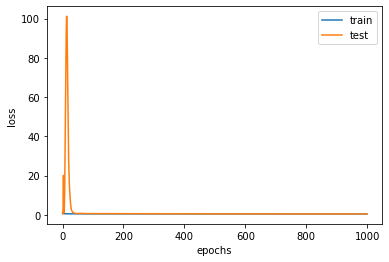

In [24]:
# On affiche les courbes loss du train et test 
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.xlabel("epochs")
plt.ylabel(list(history.history.keys())[0])
plt.show()

2022-01-16 19:05:55.799531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


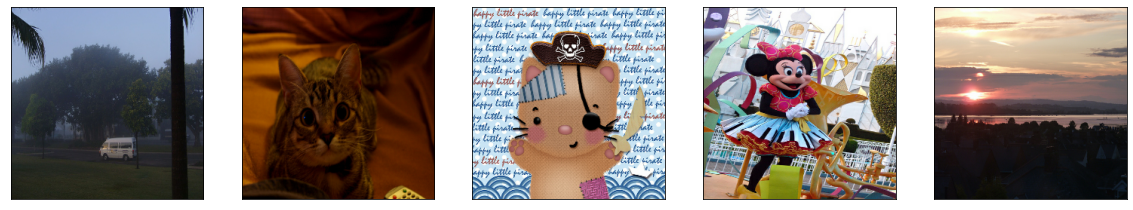

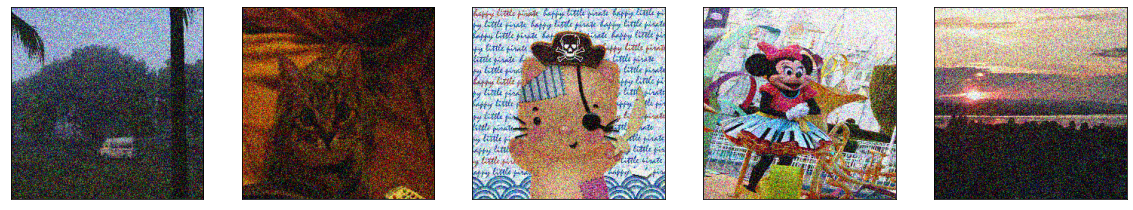

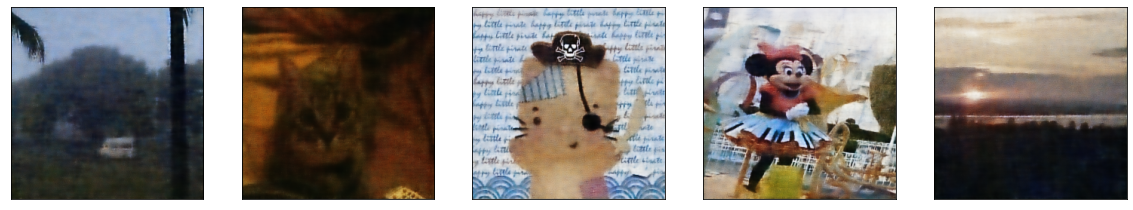

In [25]:
predictions = model.predict(x_test_noisy)
display_image(x_test, 5)
display_image(x_test_noisy, 5)
display_image(predictions, 5)

## Evaluation des performances de l'autoencodeur

Notre autoencodeur est capable de débruiter toute image, et cela avec un résultat convaincant à l'oeil nu. Evaluons à présent les performances de cet autoencodeur à l'aide d'une métrique.
Pour l'évaluer et savoir si les images générées par ce dernier sont de qualité, nous allons utiliser des méthodes de comparaison d'images. Nous allons implémenter alors le **SSIM**.

> **SSIM** : Structural SIMilarity est une mesure de similarité entre deux images numériques. La SSIM est corrélée à la qualité et à la perception du système visuel humain. Au lieu d'utiliser les méthodes traditionnelles de sommation des erreurs, la SSIM modélise la distorsion de l'image comme une combinaison de trois facteurs qui sont la perte de corrélation, la distorsion de luminance et la distorsion de contraste.

In [30]:
ssim_noisy = ssim(x_test, x_test_noisy,data_range=x_test_noisy.max() - x_test_noisy.min(), multichannel=True)
ssim_denoised = ssim(x_test, predictions,data_range=predictions.max() - predictions.min(), multichannel=True)

print(f'SSIM entre l\'image originale et celle bruitée :  {ssim_noisy}')
print(f'SSIM entre l\'image originale et celle générée :  {ssim_denoised}')

/var/folders/sj/jdct1mtx321dqtst4lqcp4ww0000gn/T/ipykernel_23009/3845260820.py:1: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0.Please use `channel_axis` instead.
  ssim_noisy = ssim(x_test, x_test_noisy,data_range=x_test_noisy.max() - x_test_noisy.min(), multichannel=True)


TypeError: Cannot interpret 'tf.float32' as a data type

### Interprétation des résultats

Nous affichons les valeurs de SSIM pour chacune de nos images. Le but étant d'avoir une valeur de SSIM la plus proche de 1 possible.
    
Nous avons une valeur moyenne de **0,96** pour l'image générée et une valeur moyenne de **0,72** pour l'image bruitée. Nous pouvons en conclure que, pour notre modèle, l'image générée est très similaire à l'image d'origine.

## Utilisation sur un autre jeu de donnée

Dans le but d'attester des bonnes performances de notre modèle nous avons décidé de réaliser une étude de cas. Nous importons alors une image qui ne fait pas parti de notre dataset de base, nous la convertissons dans le but de la rendre exploitable pour le modèle puis nous verrons alors le resultat que ça donne sur une autre image.

In [28]:
# On met l'image de test dans le bon format
input_img = PIL.Image.open('./noisy_001.jpg').convert('RGB')
input_img = input_img.resize((256, 256), PIL.Image.ANTIALIAS)
input_img = np.array(input_img, dtype=np.float32)
input_img = input_img.astype('float32')/255
input_img = tf.expand_dims(input_img, axis=0)

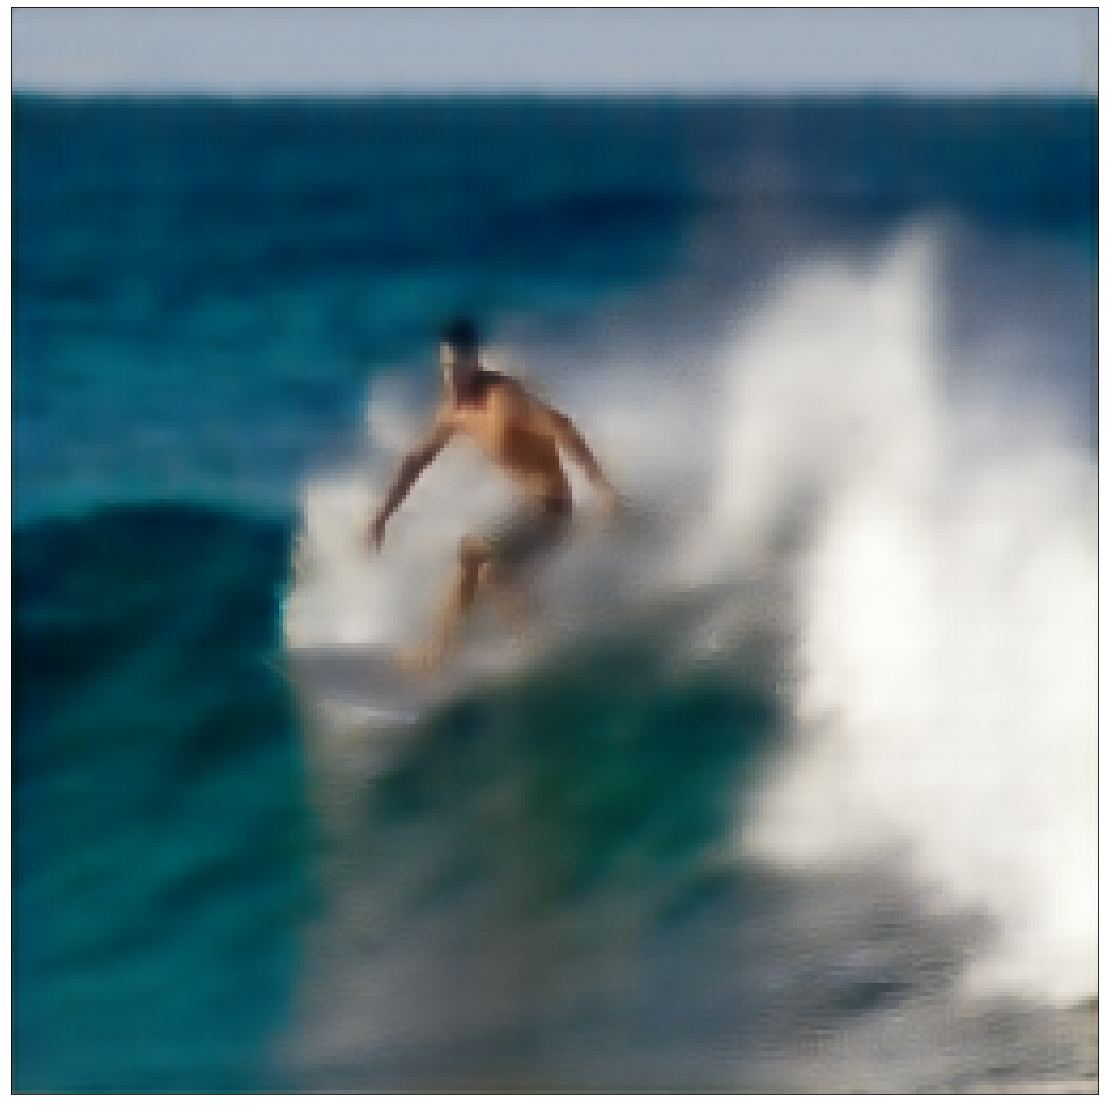

In [29]:
# Prédire une version débruité
denoised = model.predict(input_img)
display_image(denoised, n=1)